In [1]:
# Solve model using ensemble parameters
# The reference for the model is Horvath et al. 2020
# paper: https://doi.org/10.1016/j.mec.2019.e00113
# github: https://github.com/varnerlab/Kinetic-CFPS-Model-Publication-Code

include("./model/scripts/DataFile.jl");
include("./model/scripts/MassBalances.jl");
using Sundials
using Plots
using DataFrames
using CSV
using ProgressBars

# Global settings: paths and plot
PATH_OUT = "./results/"
PATH_NET = pwd()*"/model/network/Network.dat"
PATH_PARAMS = pwd()*"/model/params"
FN = "CAT_timeseries.pdf" # Output filename

# Important: select which parameter sets to solve with
#PARAMS_TO_SOLVE = collect(1:100) # all parameter sets
PARAMS_TO_SOLVE = [101] # best fit parameter set

Plots.pyplot()
fntsm = Plots.font("sans-serif", pointsize=round(10.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)

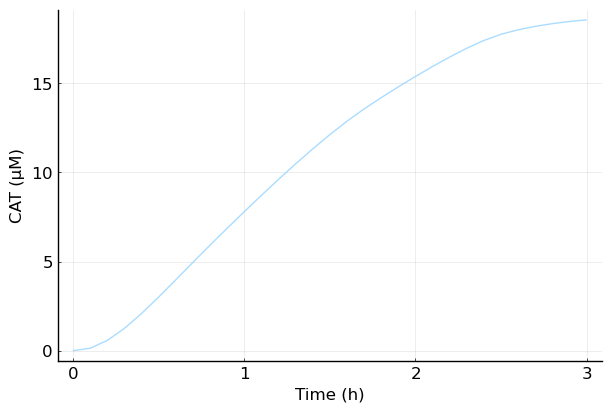

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/nadanai263/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


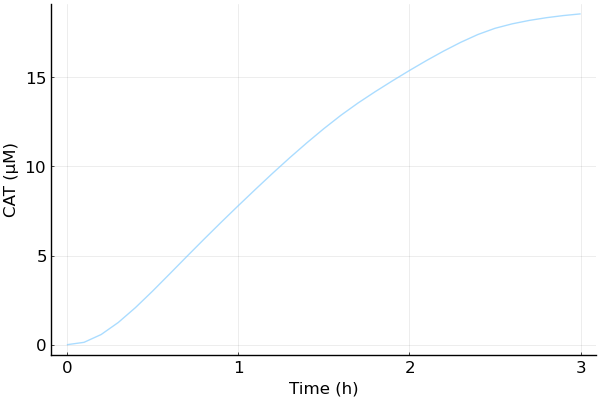

In [2]:
# 1. Load model stoichiometry, initial
# conditions, and parameters.

TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix
# and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).

# Then populate with parameters from file.

PARAMDICT = []
folders = readdir(PATH_PARAMS*"/Ensemble/") # We have 100 parameter sets

for folder in folders

    data_dictionary = DataFile(TSTART,TSTOP,Ts,PATH_NET)

    # Import initial conditions
    initial_condition_vector = vec(broadcast(abs, float(open(readdlm,PATH_PARAMS*"/initial_condition.dat"))));
    data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector;
    # Import rate constants
    rate_constant_vector = vec(broadcast(abs, float(open(readdlm,PATH_PARAMS*"/Ensemble/"*folder*"/rate_constant.dat"))));
    data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector;
    # Import saturation constants
    saturation_constant_array = broadcast(abs, float(open(readdlm,PATH_PARAMS*"/Ensemble/"*folder*"/saturation_constant.dat")));
    data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array;
    # Import control parameters
    control_constant_array = broadcast(abs, float(open(readdlm,PATH_PARAMS*"/Ensemble/"*folder*"/control_constant.dat")));
    data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array;

    push!(PARAMDICT, data_dictionary)
end

# Ready to solve
# 2. Solve ODEs, plot and save results
# selected parameter sets defined at top of script

p = plot(legend=:false,xaxis="Time (h)",yaxis="CAT (μM)")
for idx in PARAMS_TO_SOLVE
    # Set simulation timespan and initial conditions
    tspan = (TSTART,TSTOP);
    initial_condition_vector = PARAMDICT[idx]["INITIAL_CONDITION_ARRAY"];
    # Use sundials to solve fluxes.
    prob = ODEProblem(MassBalances,initial_condition_vector,tspan,PARAMDICT[idx]);
    sol = solve(prob,CVODE_BDF(),abstol=1e-12,reltol=1e-12,saveat=0.1); # very small tolerances required
    df = DataFrame(sol);  # df is 352 rows x 2508 columns
    #CSV.write(string(PATH_OUT,"solution.csv"), df) # uncomment if you want to save

    # make arrays and plot
    t=sol.t
    x=sol[98,:] # select CAT concentration
    plot!(t,x*1000,alpha=0.7,color="skyblue1")
end

savefig(PATH_OUT*FN) # Save plot